
<center><h1>💰Predicción del precio del Bitcoin💰</h1></center>

**En este notebook vamos a tratar de predecir el precio del Bitcoin**

Para lograrlo realizaremos dos modelos:

* SARIMA
* LSTM 

Finalmente, queremos comparar el desempeño de estos dos modelos mediante la métrica **rsme**

¿Qué modelo se desempeñara mejor prediciendo el precio del Bitcoin el tradicional modelo SARIMA o la red recurrente LSTM?


Versión de Tensorflow:  2.4.1


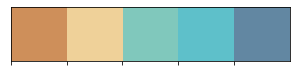

In [4]:
import pandas as pd
import numpy as np
import re
import os
import string
from datetime import datetime
import datetime, pytz
from pandas.tseries.offsets import DateOffset
from pandas.tseries.offsets import MonthEnd

#librerias de visualizacion
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import plotly
import plotly.express as px
from datetime import datetime

#####Cargando nuestro modelo de LSTM y librerias de tensor flow
from keras.models import load_model
from keras.preprocessing import text, sequence
import pickle5 as pickle
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Input
from keras.callbacks import EarlyStopping
print("Versión de Tensorflow: ", tf.__version__)

####################################### Estadística
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.stattools import adfuller      
import cupy
import cudf
import cuml
from cuml.tsa.arima import ARIMA
import itertools
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error


# Paleta de colores
my_colors = ["#ce8f5a", "#efd199", "#80c8bc", "#5ec0ca", "#6287a2"]
sns.palplot(sns.color_palette(my_colors))

# Configuración general de las gráficas
sns.set_style("white")
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

plt.style.use('ggplot')

class color:
    BOLD = '\033[1m' + '\033[93m'
    END = '\033[0m'
    


# Definición de funciones globales

In [5]:

def dateparse (time_in_secs):    
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))


def offset_png(x, y, path, ax, zoom, offset):
    
    
    img = plt.imread(path)
    im = OffsetImage(img, zoom=zoom)
    im.image.axes = ax
    x_offset = offset
    ab = AnnotationBbox(im, (x, y), xybox=(x_offset, 0), frameon=False,
                        xycoords='data', boxcoords="offset points", pad=0)
    ax.add_artist(ab)
    

    
def show_values_on_bars(axs, h_v="v", space=0.4):
        
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, format(value, ','), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
def append(my_list, value):
   
 
    my_list = my_list.tolist()
    
    my_list.append(value)
   
    my_list = cupy.asarray(my_list)
    
    return my_list      
        
def plot_prediction(actual, prediction, zoom=5000):
 
    actual_range = actual.count()
    predict_range = prediction.count()
    all_range = actual_range + predict_range
    
    plt.figure(figsize = (25, 10))
    plt.plot(range(actual_range-zoom, actual_range), actual[actual_range-zoom:actual_range].to_array(), color=my_colors[0], lw=4, label="Actual")
    plt.plot(range(actual_range, all_range), prediction.to_array(), color=my_colors[3], lw=4, ls="--", label="Predicted")
    plt.legend(fontsize=20)
    plt.title("Predicción del precio del Bitcoin", size=25)
    plt.xlabel("Tiempo", size=20)
    plt.ylabel("Log Precio", size=20)
    plt.savefig("prediccion.png",  bbox_inches='tight');    



# 📥 Importando los datos

Bitcoin shape: (4857377, 8) 
Dogecoin shape: (2501, 7)


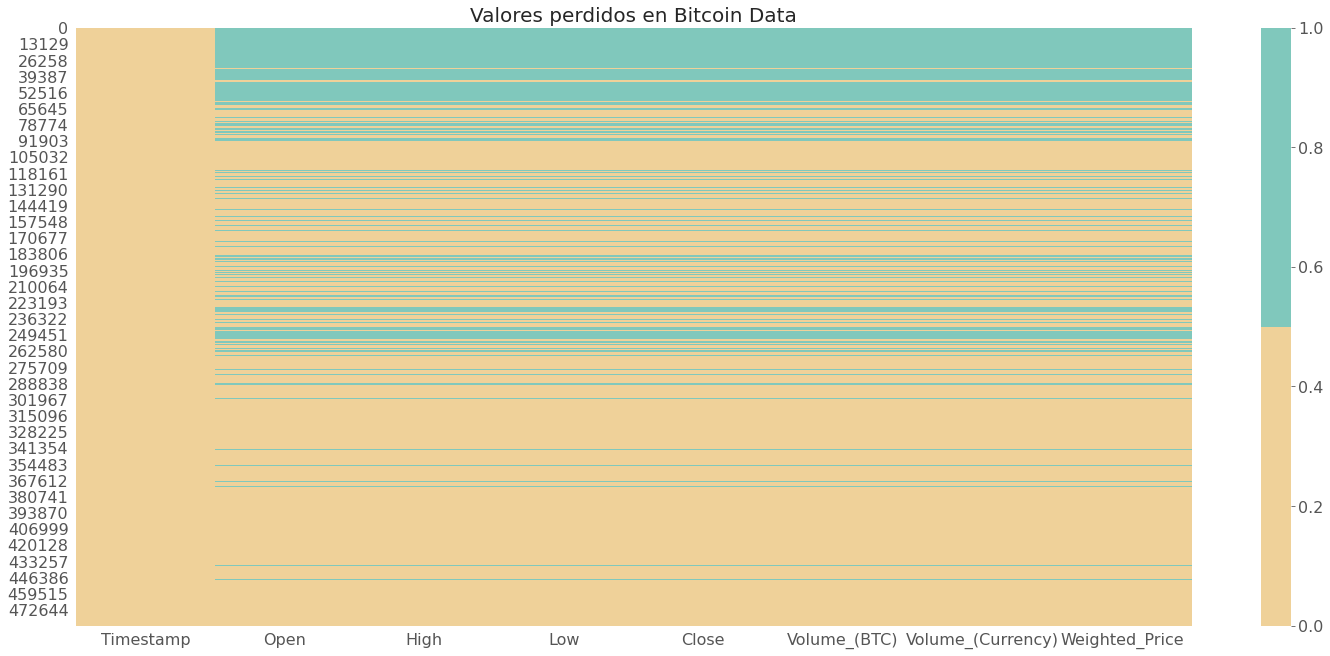

In [7]:

# === Bitcoin ===

bitcoin = pd.read_csv("../input/data-para-el-proyecto/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv", parse_dates=[0], date_parser=dateparse)

# Dimensiones de los datasets

print(color.BOLD + "Bitcoin shape:" + color.END, "{}".format(bitcoin.shape))


#Investigación superficial de los valores perdidos en cada dataset Bitcoin!

plt.figure(figsize = (25, 11))
sns.heatmap(bitcoin.isna().as_matrix()[::10], cmap = [my_colors[1], 
                                                      my_colors[2]], xticklabels=bitcoin.columns)
plt.title("Valores perdidos en Bitcoin Data", size=20);



**Visualización de los datasets**

In [8]:
#Eliminamos todos los registros que contengan informaciòn nula
bitcoin.dropna(axis=0, inplace=True)
###########3
print("Dimensión luego de eliminar los datos nulos:", bitcoin.shape)
bitcoin.head(1)

Dimensión luego de eliminar los datos nulos: (3613769, 8)


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


#  📈 Análisis de Bitcoin

In [561]:
data = bitcoin[['Timestamp', 'Weighted_Price']]
############################################## Damos formato correcto a la fecha para 
#### analizar la estacionalidad

data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='Timestamp', freq='M')]).first().reset_index()
data = data.set_index('Timestamp')
data['Weighted_Price'].fillna(method='ffill', inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



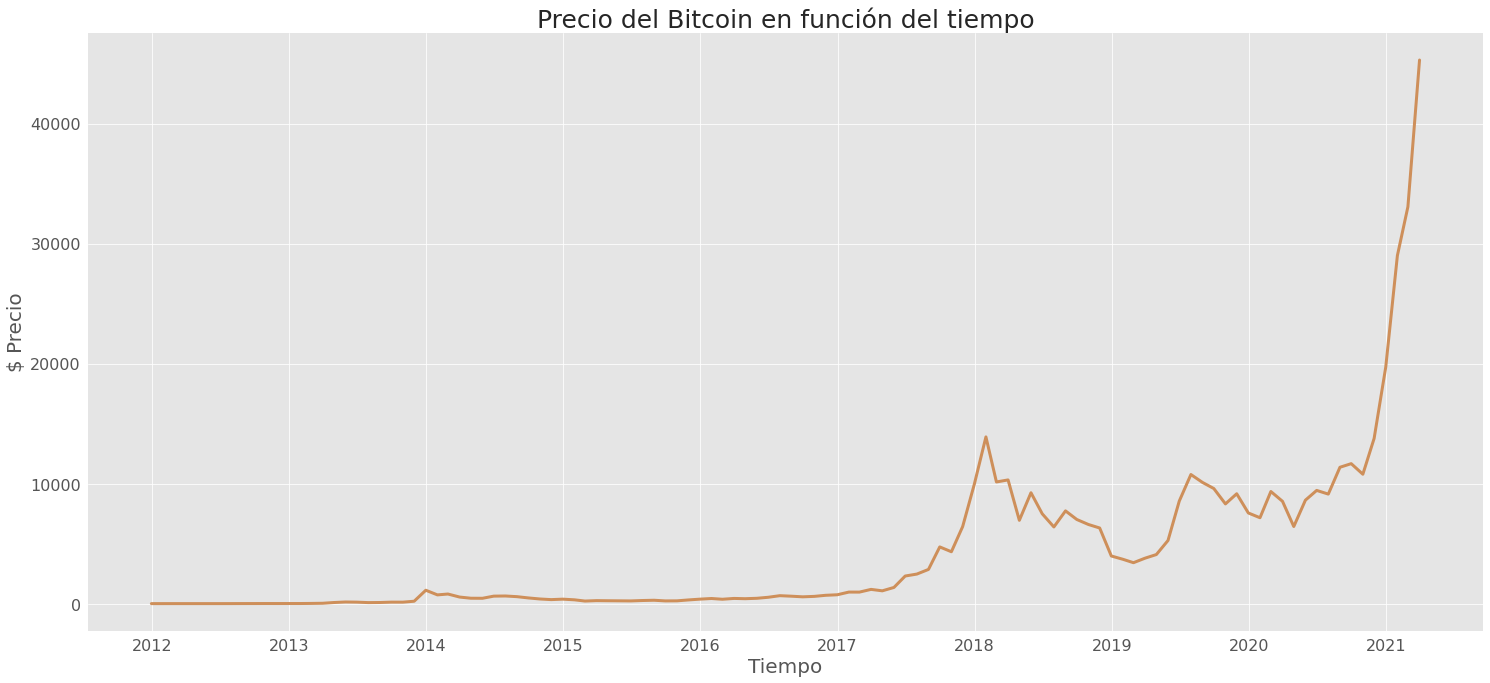

In [12]:
plt.figure(figsize = (25, 11))
plt.plot(data.index, data["Weighted_Price"], color=my_colors[0], lw=3)
plt.title("Precio del Bitcoin en función del tiempo", size=25)
plt.xlabel("Tiempo", size=20)
plt.ylabel("$ Precio", size=20)
plt.savefig("Bitcoin_plot.png", bbox_inches='tight');

In [87]:
wandb.log({"Precio del Bitcoin desde el 2012 hasta el 2021": wandb.Image("./Bitcoin_plot.png")})

**Análisis de estacionalidad**

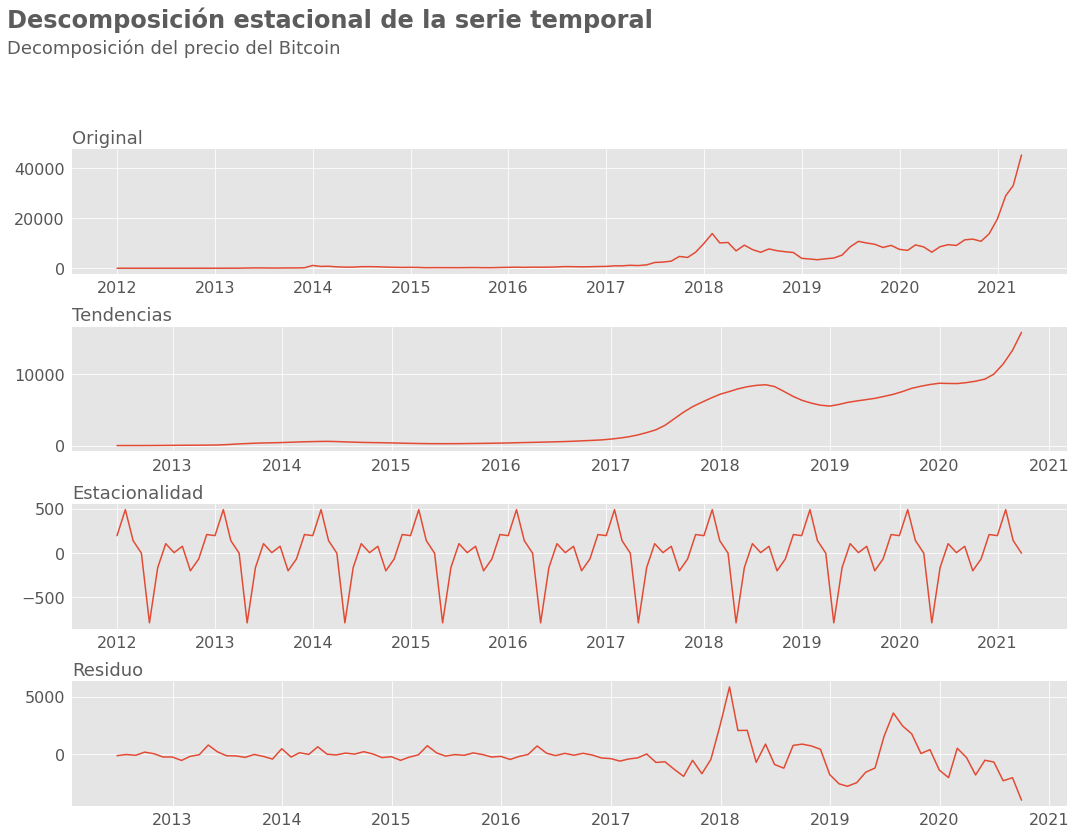

In [13]:
ax, fig = plt.subplots(figsize=(15,10), sharex=True)

df_month = data.resample("M").mean()
dec = sm.tsa.seasonal_decompose(df_month["Weighted_Price"])


plt.subplot(411)
plt.plot(data["Weighted_Price"], label="Weighted Price")
plt.title("Original",loc="left", alpha=0.75, fontsize=18)

plt.subplot(412)
plt.plot(dec.trend, label="Tendencia")
plt.title("Tendencias",loc="left", alpha=0.75, fontsize=18)

plt.subplot(413)
plt.plot(dec.seasonal, label="Estacionalidad")
plt.title("Estacionalidad",loc="left", alpha=0.75, fontsize=18)

plt.subplot(414)
plt.plot(dec.resid, label="Residuo")
plt.title("Residuo",loc="left", alpha=0.75, fontsize=18)
plt.tight_layout()

plt.text(x=datetime.date(2011, 6, 30), y=63000, s="Descomposición estacional de la serie temporal",fontsize=24, weight="bold", alpha=0.75)
plt.text(x=datetime.date(2011, 6, 30), y=60700, s="Decomposición del precio del Bitcoin",fontsize=18, alpha=0.75)
plt.savefig("estacionalidad.png", bbox_inches='tight');


Del gráfico anterior podemos ver algunas cosas:

* Los precios de Bitcoin se enfrentan a una fuerte tendencia al alza.
* Hay algunos elementos estacionales en el precio (+- 500)
* La mayor parte del ruido en los datos se generó durante la fase de "hype" de 2018-2019

# 🔎 Estacionalidad

> En esta sección vamos a revisar si nuestros datos tienen algún tipo de estacionalidad o no. Debemos revisar esto antes de poder aplicar algún modelo.

> Para examinar la estacionalidad de nuestros datos, vamos a emplear la siguiente método:

> ***Prueba de Dickey-Fuller aumentada***: Determina que tan fuerte en es la tendencia en una serie.

> ${\displaystyle \Delta y_{t}=\alpha +\beta t+\gamma y_{t-1}+\delta _{1}\Delta y_{t-1}+\cdots +\delta _{p-1}\Delta y_{t-p+1}+\varepsilon _{t},}$

> En donde $\alpha$ es una constante, $\beta$ el coeficiente sobre una tendencia temporal y > $p$ el orden de retraso.

> **Hipótesis de la prueba:**

> * Hipótesis nula: La serie de tiempo puede representarse por uan raíz unitaria, es decir no es estacionaria.

> * Hipótesis alterna: La serie de tiempo es estacionaria

> Si la serie de tiempo es estacionaria significa que las propiedades estadísticas del sistema son constantes en el tiempo. Sin embargo, lo anterior **no** significa que cada dato tenga el mismo valor en cada instante de tiempo.


> **Evaluación de la prueba**

> Vamos a rechazar o aceptar alguna de las dos hipótesis anteriores mediante el p-valor:

> * p-valor > 0.05: Aceptamos la hipótesis nula y la serie es NO estacionaria.

> * p-valor < = 0.05: Rechazamos la hipótesis nula y la series SI es estacionaria.

In [14]:
def test_stationarity(x, log="non-stationary"):
    '''Prueba de estacionalidad'''
    
    # Realizamos la prueba de  Dickey-Fuller sobre una variable
    result = adfuller(x)
    print('Estadistica ADF: %f'%result[0])
    print('p-valor: %f'%result[1])
    pvalue=result[1]
    
    for key,value in result[4].items():
        if result[0]>value:
            print(color.BOLD + "La serie es no estacionaria, tiene una tendencia" + color.END)
            wandb.log({log : round(result[1], 5)})
            break
        else:
            print(color.BOLD + "La serie es ¡Estacionaria!" + color.END)
            wandb.log({log : round(result[1], 5)})
            break;
    
    print('Valores críticos:')
    for key,value in result[4].items():
        print('\t%s: %.3f ' % (key, value))
    
    # Determinando algunas estadísticas 
    rolmean = x.rolling(window=22,center=False).mean()
    rolstd = x.rolling(window=12,center=False).std()
    
    # Plot
    plt.figure(figsize=(25, 11))
    orig = plt.plot(x, color=my_colors[0], lw=8, label='Original')
    mean = plt.plot(rolmean, color=my_colors[2], lw=2.5, ls="--",  label='Media Móvil')
    std = plt.plot(rolstd, color=my_colors[3], lw=3, label = 'Std Móvil')
    plt.legend(loc='best', fontsize=20)
    plt.title('Media Móvil y desviación estándar', size=25)
    plt.savefig("estacionaria.png", bbox_inches='tight')
    plt.show(block=False)
   
    
   

Estadistica ADF: 2.660397
p-valor: 0.999084
	1%: -3.492 
	5%: -2.888 
	10%: -2.581 


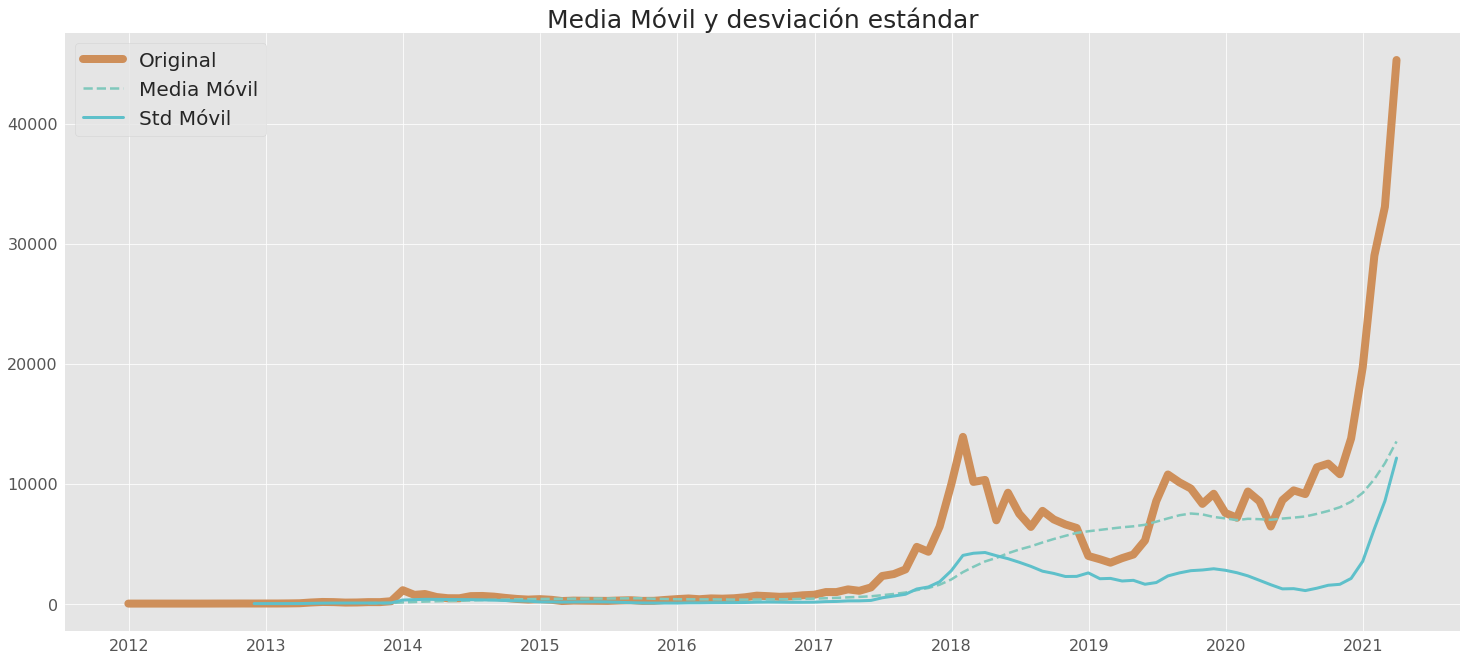

In [21]:
#Ejecución de la función anterior

price = pd.Series(data["Weighted_Price"])
test_stationarity(price)

Debemos aceptar la hipótesis nula, debido a que el p-valor es mayor que 0.05. Por lo tanto, debemos hacer algunas transformaciones para eliminar la tendencia de la serie.

# 📚 De una serie NO estacionaria ---------> ¡Estacionaria!

> Debido a que en la sección anterior encontramos que nuestra serie de tiempo (Precio del Bitcoin) tiene tendencia, debemos eliminarla para aplicar los modelos.

> * Una de las aproximaciones es aplicar la transformación Box-cox:


In [15]:
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Weighted_Price)
print("Prueba de Dickey–Fuller: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price_box)[1])

Prueba de Dickey–Fuller: p=0.943554


In [16]:
df_month['Weighted_Price_log'] = np.log(df_month['Weighted_Price'] )
print("Prueba de Dickey–Fuller: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price_log)[1])

Prueba de Dickey–Fuller: p=0.594426


Prueba de Dickey–Fuller: p=0.94, p=0.59. **Bajo las transformaciones de Box-cox y log la serie sigue siendo no estacionaria**

**Diferenciación: Debido a que se obtuvo un p-valor más pequeño con la transformación logarítmica usaremos esta nueva variable para realizar el proceso de diferenciación y verificar que la serie es estacionaria.**

Adicionalmente, en la gráfica en donde realizamos la descomposición de la serie logramos ver que esta tenía un comportamiento estacional de aproximadamente un año. Podemos incluir este resultado en nuestro proceso de diferenciación.

In [17]:

first_diff = df_month["Weighted_Price_log"].diff()
print("Dicky-Fuller stationarity test - p: %f" % sm.tsa.adfuller(first_diff[1:])[1])
print("This series is stationary")


df_month["Auto_Diff"] = first_diff

Dicky-Fuller stationarity test - p: 0.000000
This series is stationary


**Analicemos la descomposición de esta nueva variable estacionaria**

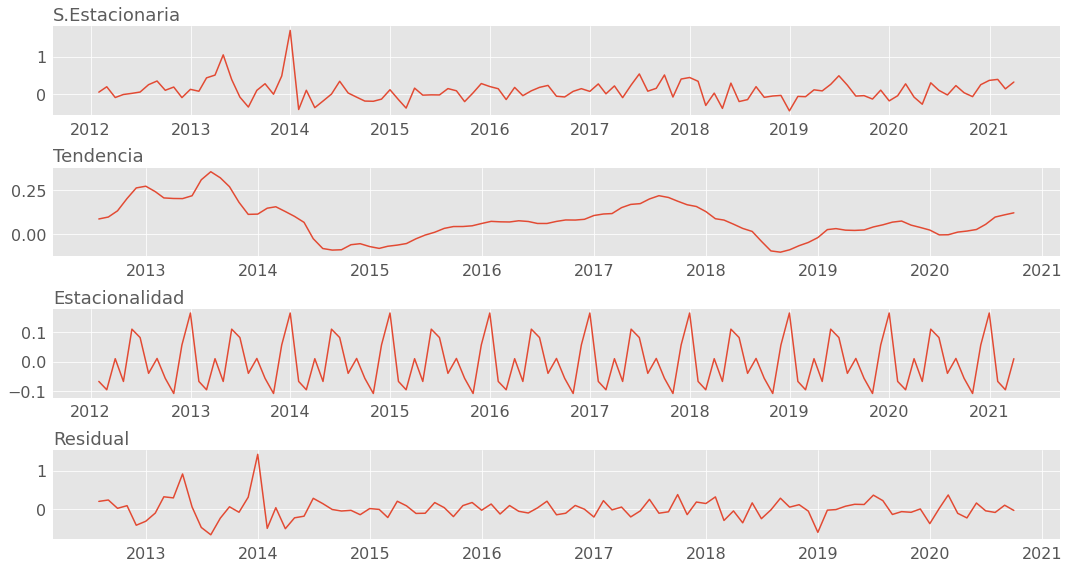

In [18]:

#Data
seasonal_dec = sm.tsa.seasonal_decompose(df_month[ "Auto_Diff"][1:])

#Seasonal Decompose on stationary series
ax, fig = plt.subplots(figsize=(15,8), sharex=True)

df_month_ = data.resample("M").mean()
dec = sm.tsa.seasonal_decompose(df_month_["Weighted_Price"])


plt.subplot(411)
plt.plot(df_month[ "Auto_Diff"], label="Weighted Price")
plt.title("S.Estacionaria",loc="left", alpha=0.75, fontsize=18)

plt.subplot(412)
plt.plot(seasonal_dec.trend, label="Tendencia")
plt.title("Tendencia",loc="left", alpha=0.75, fontsize=18)

plt.subplot(413)
plt.plot(seasonal_dec.seasonal, label="Estacionalidada")
plt.title("Estacionalidad",loc="left", alpha=0.75, fontsize=18)

plt.subplot(414)
plt.plot(seasonal_dec.resid, label="Residual")
plt.title("Residual",loc="left", alpha=0.75, fontsize=18)
plt.tight_layout()




plt.savefig("estacionalidad_estacionaria.png", bbox_inches='tight');


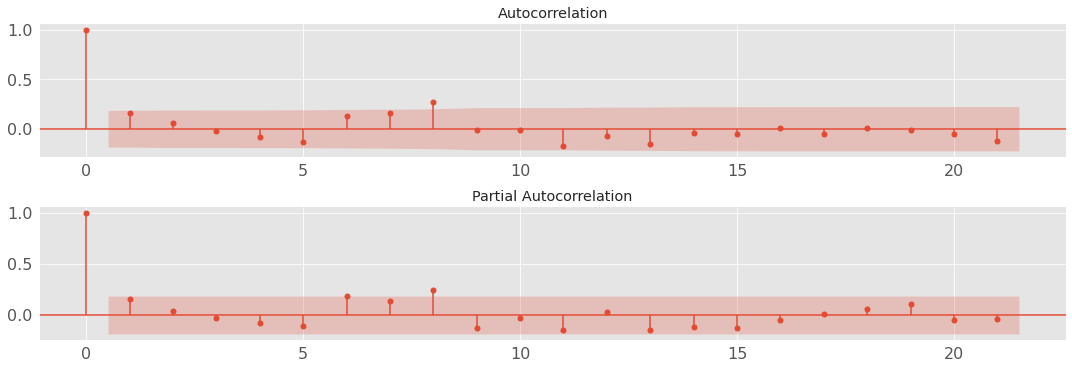

In [26]:

ax, fig = plt.subplots(figsize=(15,10))

plt.subplot(411)
x = sm.graphics.tsa.plot_acf(first_diff[1:], ax=plt.gca())
plt.subplot(412)
y = sm.graphics.tsa.plot_pacf(first_diff[1:],ax=plt.gca())
plt.savefig("autocorrelacion.png", bbox_inches='tight')
plt.tight_layout()


del x,y

*Nuestra última aproximación parece tener un comportamiento mucho más estacionario.*

# 🎇 Selección del  Modelo

 > **SARIMA**
 > * S: Modelo estacional
 > * AR: Modelo autoregresivo
 > * I: Integrado
 > * MA: Media Móvil

 > **Parámetros del modelo:*

 > El modelo SARIMA tiene los siguientes parámetros (p,d,q)x(P,D,Q). Cada uno de los parámetros hace referencia a lo siguiente:
 
 * p: Orden del moelo autoregresivo (AR)
 * d: Número de diferenciaciones aplicadas a la serie original
 * q: El orden del modelo de promedio móviles(MA)
 * P: El orden del Modelo Autoregresivo Estacional
 * D:  Número de diferenciaciones aplicadas a la serie original de manera Estacional
 * S: El orden del modelo de promedios móviles estacional


 > **Criterios**

 > Para determinar el desempeño de nuestro modelo podemos emplear las siguientes métricas:

 > * Función de verosimilitud:

 > ${\displaystyle {\mathcal {L}}(\theta \mid x)=f_{\theta }(x),\,}$

 > * Criterio de información de Akaike:

 > ${\displaystyle {\mathrm {AIC}}=2k-2\ln(L)}$, en donde $k$ es el número de parámetros del modelo estadístico y $L$ es el máximo valor de la función de verosimilitud del modelo.

 > * Criterio de información Bayesiano:

 > ${\displaystyle \mathrm {BIC} ={-2\cdot \ln {\hat {L}}+k\ln(n)}}$, en donde $k$ es el número de parámetros libres del modelo, $n$ es el tamaño de la muestra y 
${\displaystyle {\hat {L}}}$ corresponde al máximo valor de la función de verosimilitud del modelo ${\displaystyle M}$, ${\displaystyle {\hat {L}}=p(x|{\hat {\theta }},M)}$.

 > Todas las métricas anteriores miden la pérdida de información. Entre menos información perdamos mejor es nuestro modelo.

**Para realizar nuestro análisis vamos a emplear SARIMAX.**

* Primero vamos a encontrar los mejores parámetros que se ajusten al modelo. Para lograrlo crearemos un vector con todas las combinaciones posibles que pueden tomar estos.

* Posteriormente, evaluaremos cada uno de los modelos resultantes mediante el AIC. 

* Escogeremos los mejores parámetros aquellos que permitan tener un modelo con el menor valor de AIC.

In [20]:
###SARIMAX###

#Construimos las posibles combinaciones de paramétros.
p = d = q = range(0,2)

#También podríamos buscar estos valores a partir de las gráficas de autocorrelación
#Probemos este método y luego comparamos los resultados 

pdq = list(itertools.product(p,d,q))

seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]

In [21]:
def sarimax_function(data,pdq,s_pdq):

    """
      Esta función nos ayuda evaluar y encontrar los mejores parámetros 
      del modelo empleando la métrica AIC como referencia para el
      contraste de resultados.
    """

    result_list = []
    for param in pdq:
        for s_param in s_pdq:

            model = sm.tsa.statespace.SARIMAX(data, order=param, seasonal_order=s_param,
            enforce_invertibility=False,enforce_stationarity=False)

            results = model.fit()
            result_list.append([param,s_param,results.aic])
            print("ARIMA Parameters: {} x: {}. AIC: {}".format(param,s_param,results.aic))

    return result_list,results

In [22]:
result_list,results = sarimax_function(df_month["Weighted_Price"],pdq,seasonal_pdq)

ARIMA Parameters: (0, 0, 0) x: (0, 0, 0, 12). AIC: 2313.354824090775
ARIMA Parameters: (0, 0, 0) x: (0, 0, 1, 12). AIC: 2123.4088308437085
ARIMA Parameters: (0, 0, 0) x: (0, 1, 0, 12). AIC: 2007.7511333958278
ARIMA Parameters: (0, 0, 0) x: (0, 1, 1, 12). AIC: 1779.9632163387953
ARIMA Parameters: (0, 0, 0) x: (1, 0, 0, 12). AIC: 2019.7071052206363
ARIMA Parameters: (0, 0, 0) x: (1, 0, 1, 12). AIC: 1977.9952511956326
ARIMA Parameters: (0, 0, 0) x: (1, 1, 0, 12). AIC: 1797.1110648372742
ARIMA Parameters: (0, 0, 0) x: (1, 1, 1, 12). AIC: 1775.2661822168873
ARIMA Parameters: (0, 0, 1) x: (0, 0, 0, 12). AIC: 2228.8001392759816
ARIMA Parameters: (0, 0, 1) x: (0, 0, 1, 12). AIC: 2056.104240014652
ARIMA Parameters: (0, 0, 1) x: (0, 1, 0, 12). AIC: 1935.6514652854755
ARIMA Parameters: (0, 0, 1) x: (0, 1, 1, 12). AIC: 1690.0430194659525
ARIMA Parameters: (0, 0, 1) x: (1, 0, 0, 12). AIC: 1947.963237112529
ARIMA Parameters: (0, 0, 1) x: (1, 0, 1, 12). AIC: 1869.214646871645
ARIMA Parameters: (0, 0,

In [23]:
#Creamos un dataframe con los resultados..

results_dataframe = pd.DataFrame(result_list, columns=["dpq","s_dpq","aic"]).sort_values(by="aic")
results_dataframe.head()

,dpq,s_dpq,aic
63,"(1, 1, 1)","(1, 1, 1, 12)",1522.878161
59,"(1, 1, 1)","(0, 1, 1, 12)",1526.745716
47,"(1, 0, 1)","(1, 1, 1, 12)",1545.180695
31,"(0, 1, 1)","(1, 1, 1, 12)",1546.626909
43,"(1, 0, 1)","(0, 1, 1, 12)",1547.210444


**Para determinar los mejores parámetros debemos encontrar el menor valor de la métrica AIC, que representa menor pérdida de información, por lo tanto los mejores parámetros para el modelo son (1,1,1). Notemos que el modelo también nos da unos parámetros s_dpq, que me indican el orden de estacionalidad en este caso (1,1,1,12), serían los mejores parámetros**

Nota: La componente estacional resultó ser 12 tal como vimos en la sección anterior!

# 🚀 Predicción del precio del Bitcoin con SARIMA

 > Ahora, vamos a predecir los precios de Bitcoin utilizando el modelo SARIMA con los parámetros encontrados en la sección anterior



**Configuramos nuestro modelo SARIMA empleando los parámetros encontrados en la sección anterior**

In [55]:
model = sm.tsa.statespace.SARIMAX(df_month["Weighted_Price"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12),
            enforce_invertibility=False,enforce_stationarity=False).fit()
print(model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1456      0.053     21.647      0.000       1.042       1.249
ma.L1         -0.6818      0.100     -6.825      0.000      -0.878      -0.486
ar.S.L12      -0.4010      0.134     -2.991      0.003      -0.664      -0.138
ma.S.L12      -0.7092      0.105     -6.780      0.000      -0.914      -0.504
sigma2      3.067e+06   2.86e+05     10.721      0.000    2.51e+06    3.63e+06


**Análisis de los resultados**

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


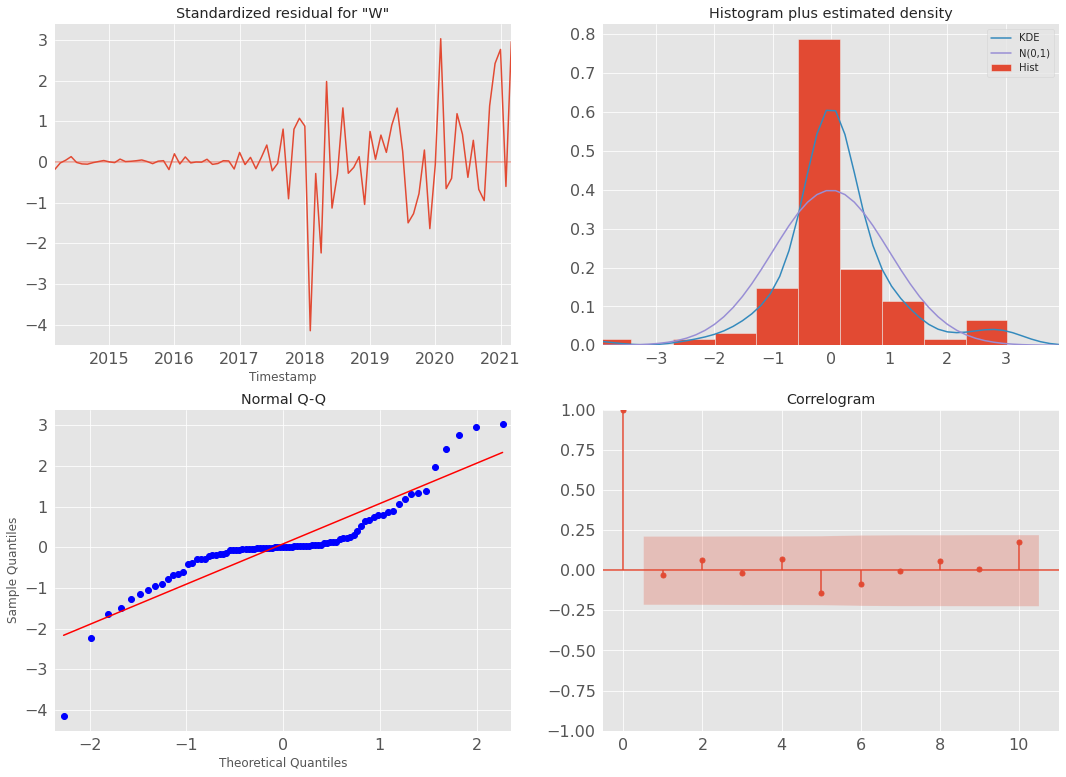

In [56]:
x = model.plot_diagnostics(figsize=(18, 13))
plt.savefig("resultados_modelo_sarima.png", bbox_inches='tight' )

**Predicciones**

In [85]:
df_month_prediction = df_month[["Weighted_Price"]]

df_month_prediction["Forcasting"] = model.predict(start=pd.to_datetime("2019-01-31"), end=pd.to_datetime("2021-03-31"))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


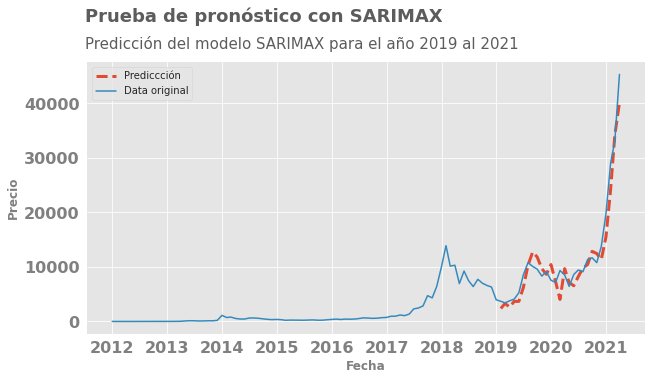

In [86]:
ax, fig = plt.subplots(figsize = (10,5))

plt.plot(df_month_prediction["Forcasting"], ls="--",lw=3, label="Prediccción")
plt.plot(df_month_prediction["Weighted_Price"], label="Data original")

plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Fecha",alpha=0.75, weight="bold")
plt.ylabel("Precio",alpha=0.75, weight="bold")

plt.legend()

plt.text(x=datetime.date(2011, 6, 30), y=55000, s="Prueba de pronóstico con SARIMAX",
fontsize=18, weight="bold", alpha=0.75)
plt.text(x=datetime.date(2011, 6, 30), y=50000, s="Predicción del modelo SARIMAX para el año 2019 al 2021",fontsize=15, alpha=0.75)
plt.savefig("prediccion_sarima.png", bbox_inches='tight' )

**Estimación del error del modelo**


In [92]:
df_month_prediction_ = df_month_prediction.dropna()
rms_sarimax = np.sqrt(np.mean(np.power(df_month_prediction_["Forcasting"] -df_month_prediction_.Weighted_Price,2)))
mse_sarimax = mean_squared_error(df_month_prediction_["Forcasting"], df_month_prediction_.Weighted_Price)
mae_sarimax = median_absolute_error(df_month_prediction_.Weighted_Price, df_month_prediction_["Forcasting"])
print("MAE:",mae_sarimax)
print("RMS:", rms_sarimax)
print("MSE", mse_sarimax)

MAE: 1315.415508212327
RMS: 2358.993378183706
MSE 5564849.758314574


**Usando el modelo para predecir el futuro-----> un año**

In [93]:
future_dates = [df_month_prediction.index[-1] + DateOffset(months = x)for x in range(1,12)]
future_dates = pd.to_datetime(future_dates)  +  MonthEnd(0)
future = pd.DataFrame(index=future_dates)
df_month_prediction = pd.concat([df_month_prediction,future])

########################################-----Prediccion-----#############
#-------------------------------------------------------------------------
######################################################################

df_month_prediction["Future_forcast"] = model.predict(start=pd.to_datetime("2021-03-31"),end=pd.to_datetime("2022-03-31"))

pred = model.get_prediction(start=pd.to_datetime("2021-03-31"),end=pd.to_datetime("2022-03-31"))
pred_ci = pred.conf_int()



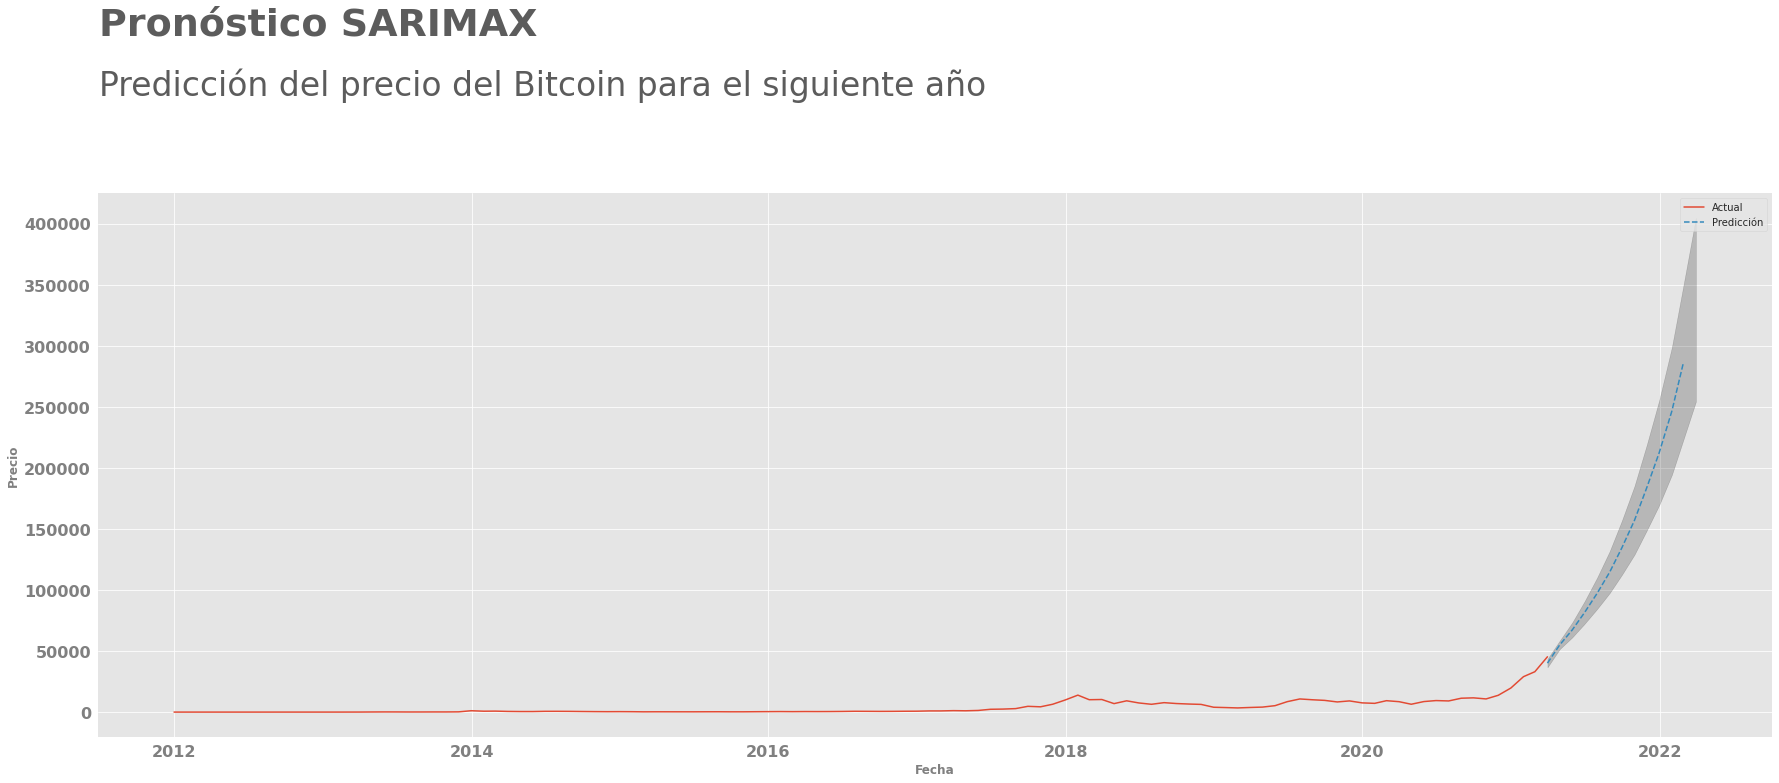

In [106]:
ax, fig = plt.subplots(figsize=(30,10))

plt.plot(df_month_prediction["Weighted_Price"], label="Actual")
plt.plot(df_month_prediction["Future_forcast"],ls="--", label="Predicción")

plt.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.legend()


plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Fecha",alpha=0.75, weight="bold")
plt.ylabel("Precio",alpha=0.75, weight="bold")

plt.legend()

plt.text(x=datetime.date(2011, 6, 30), y=555000, s="Pronóstico SARIMAX ",
fontsize=38, weight="bold", alpha=0.75)
plt.text(x=datetime.date(2011, 6, 30), y=505000, s="Predicción del precio del Bitcoin para el siguiente año",fontsize=33, alpha=0.75)
plt.savefig("prediccion_sarima_un_anio.png", bbox_inches='tight' )

# 🚀 Predicción del precio del Bitcoin empleando LSTM

<img src="https://cdn-images-1.medium.com/max/1600/0*LyfY3Mow9eCYlj7o.">

Fuente: [Medium](https://codeburst.io/generating-text-using-an-lstm-network-no-libraries-2dff88a3968)

Explicación: https://medium.com/deep-math-machine-learning-ai/chapter-10-1-deepnlp-lstm-long-short-term-memory-networks-with-math-21477f8e4235


**Empleamos los datos procesados en la sección anterior**

In [110]:
data = df_month[['Weighted_Price']]
data

,Weighted_Price
Timestamp,
2011-12-31,4.390000
2012-01-31,4.580000
2012-02-29,5.525435
2012-03-31,4.990000
2012-04-30,4.890000
...,...
2020-11-30,13765.082827
2020-12-31,19715.528676
2021-01-31,29005.427056


**Para entrenar nuestro modelo debemos seleccionar un conjunto de prueba y de entrenamiento**

112 = 86 + 27


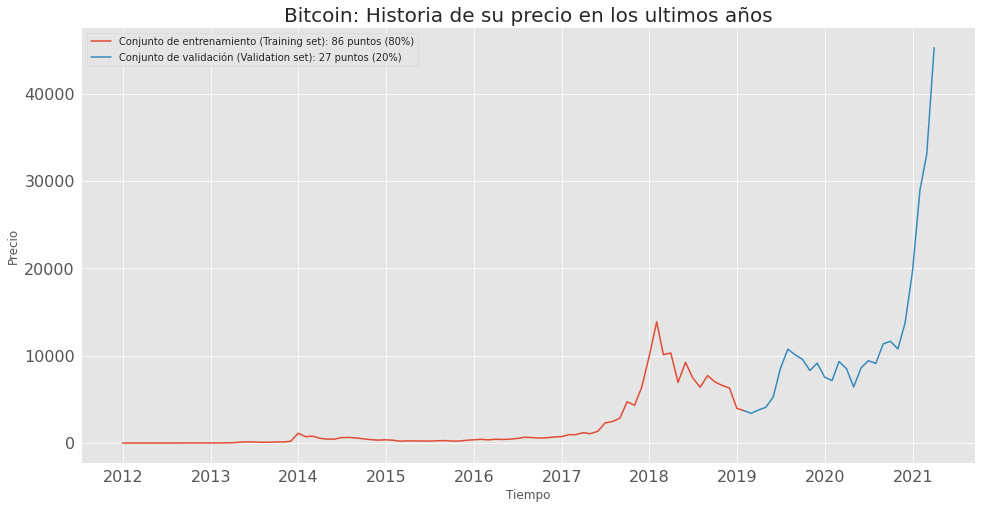

In [116]:
# plot
len_data = len(data)
len_train = len(data[:'2019-01-31'])
len_test = len(data['2019-01-31':])
print (len_data, '=', len_train, '+',len_test)

plt.figure(figsize=(16,8))
plt.plot(data['Weighted_Price'][:'2019-01-31'], label='Conjunto de entrenamiento (Training set): {} puntos (80%)'.format(len_train))
plt.plot(data['Weighted_Price']['2019-01-31':], label='Conjunto de validación (Validation set): {} puntos (20%)'.format(len_test)) #248 data
plt.title("Bitcoin: Historia de su precio en los ultimos años", size = 20)
plt.ylabel("Precio")
plt.xlabel("Tiempo")
plt.legend()
plt.savefig("bitcoin_lstm.png", bbox_inches='tight')
plt.show()

**Preparación de los datos**

Para poder entrenar nuestra red LSTM necesitamos realizar un preprocesamienot adicional a nuestro datos, como por ejemplo escalarlos.

In [534]:
#Definimos los datos de entrenamiento y de prueba
X_train,X_test=data[:'2019-01-31'],data['2019-01-31':]

#Escalamos los datos entre 0,1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_train  = np.squeeze(np.array(scaler.fit_transform(X_train)),axis=1)
scaled_data_test = np.squeeze(np.array(scaler.transform(X_test)),axis=1)

**Creación del conjunto de entrenamiento y de prueba**

Inpunt:
* Número de datos consecutivos para entrenamiento: time_step = 3  *aproximadamente 90 días*

* Recordemos que la red LSTM recibe un tensor de tres dimensiones por lo tanto debemos ajustar nuestros vectores a la dimensión correcta.

In [535]:
tf.random.set_seed(100)#Semilla para garantizar los resultados en cada entrenamiento
len_data = len(data)
def create_dataset(data,timestamp=1):
    X=[]
    Y=[]
    
    for i in range(len(data)-timestamp-1):
        a = data[i:(i+timestamp)]
        X.append(a)
        
        Y.append(data[i+timestamp])
        
    return np.array(X),np.array(Y)


past_history=3
X_train,y_train = create_dataset(scaled_data_train,past_history)
X_test,y_test = create_dataset(scaled_data_test,past_history)


X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))#Creamos los tensores para train
y_train = np.reshape(y_train, (y_train.shape[0],1,1))

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))#Creamos los tensores para train
y_test = np.reshape(y_test, (y_test.shape[0],1,1))
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)



(82, 3, 1)
(82, 1, 1)
(23, 3, 1)
(23, 1, 1)


**Definición de la arquitectura de la LSTM**

* Creamos una red neuronal con dos capas LSTM.
* La primera capa tiene 280 unidades de las cuales el 40% se desactivan aleatoriamente (con el fin de disminuir el posible sobreajuste en los datos)
* La segunda capa LSTM consta de 30 unidades y cambiamos la función de activación por relu.
* Finalmente, empleamos la función *EarlyStopping* con el objetivo de interrumpir el entrenamiento de la red cuando su pérdida no varie o cuando esta comienze a incrementar.
* Para medir la pérdida vamos a emplear la MSE

In [536]:
# Dimensión de entrada
stop = EarlyStopping(monitor="val_loss", patience=1, verbose=1, mode="auto",)

model = Sequential()

model.add(LSTM(280,return_sequences = True,input_shape = (5,1),activation='relu'))
model.add(Dropout(0.4))
model.add(LSTM(30,return_sequences = False,activation='relu'))

model.add(Dense(1))

model.compile(optimizer='adam',loss='mean_squared_error')
model.summary()

Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_237 (LSTM)              (None, 5, 280)            315840    
_________________________________________________________________
dropout_138 (Dropout)        (None, 5, 280)            0         
_________________________________________________________________
lstm_238 (LSTM)              (None, 30)                37320     
_________________________________________________________________
dense_95 (Dense)             (None, 1)                 31        
Total params: 353,191
Trainable params: 353,191
Non-trainable params: 0
_________________________________________________________________


**Entrenando la RNN**

In [537]:
history = model.fit(
    X_train, y_train,
    epochs=600,
    batch_size= 5,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
    callbacks=[stop]
)

#Guardamos el modelo
model.save('history_LSTM.h5')

Epoch 1/600
15/15 [==============================] - 2s 37ms/step - loss: 0.0064 - val_loss: 0.2243
Epoch 2/600
15/15 [==============================] - 0s 16ms/step - loss: 0.0057 - val_loss: 0.1956
Epoch 3/600
15/15 [==============================] - 0s 16ms/step - loss: 0.0057 - val_loss: 0.1590
Epoch 4/600
15/15 [==============================] - 0s 16ms/step - loss: 0.0066 - val_loss: 0.1175
Epoch 5/600
15/15 [==============================] - 0s 18ms/step - loss: 0.0080 - val_loss: 0.0744
Epoch 6/600
15/15 [==============================] - 0s 16ms/step - loss: 0.0085 - val_loss: 0.0313
Epoch 7/600
15/15 [==============================] - 0s 16ms/step - loss: 0.0069 - val_loss: 0.0118
Epoch 8/600
15/15 [==============================] - 0s 17ms/step - loss: 0.0037 - val_loss: 0.1121
Epoch 00008: early stopping


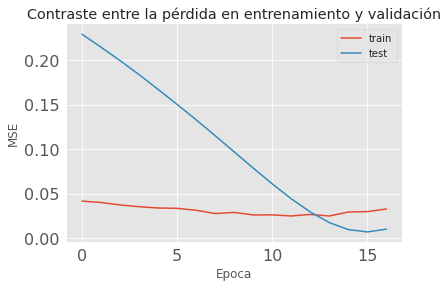

In [491]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.xlabel("Epoca")
plt.ylabel("MSE")
plt.title("Contraste entre la pérdida en entrenamiento y validación")
plt.savefig("funcion_perdida_LSTM.png",bbox_inches='tight');

**Predicciones**

In [538]:
# predicciones
pred = model.predict(X_test)


#Eliminamos las dimensiones sobrantes para poder visualizar los resultados
y_train_p = np.squeeze(y_train, axis=-1)
y_test_p =  np.squeeze(y_test, axis=-1)
y_pred_p =  np.squeeze(pred, axis=-1)




#y_test_p = y_test_p.reshape(-1)
print(y_train_p.shape)
print(y_test_p.shape)
print(y_pred_p.shape)

(82, 1)
(23, 1)
(23,)


In [539]:
def return_rmse(test,predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    
return_rmse(y_test_p, y_pred_p)


The root mean squared error is 0.25917923809666416.


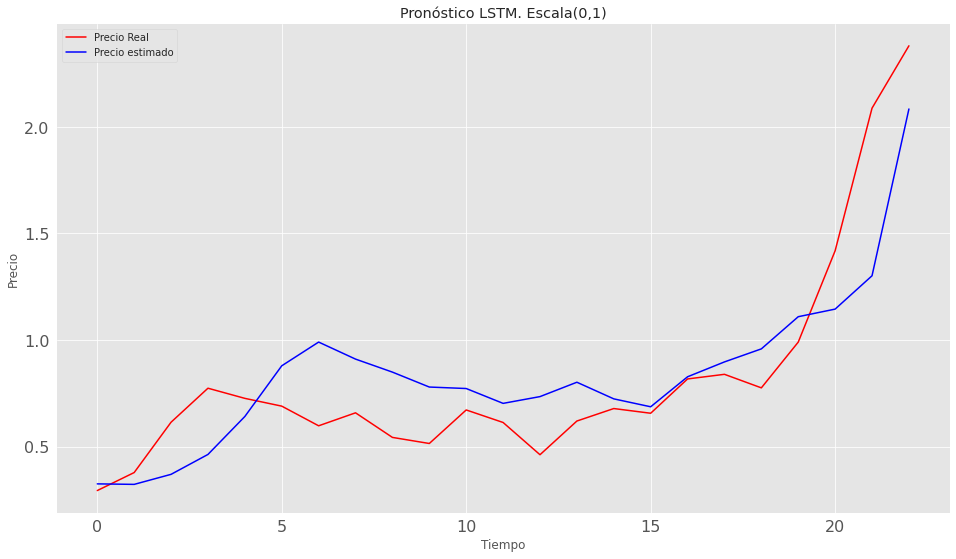

In [540]:
# Some functions to help out with
def plot_predictions(test,predicted):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    plt.plot(test, color='red',label='Precio Real')
    plt.plot(predicted, color='blue',label='Precio estimado')
    plt.title('Pronóstico LSTM. Escala(0,1)')
    plt.xlabel('Tiempo')
    plt.ylabel('Precio')
    plt.legend()
    plt.savefig("bitcoin_acercamiento_LSTM.png",bbox_inches='tight');
    plt.show()
    

    
plot_predictions(y_test_p,y_pred_p)

In [521]:
wandb.log({"Resultado del Prónostico con LSTM": wandb.Image("./bitcoin_acercamiento_LSTM.png")})

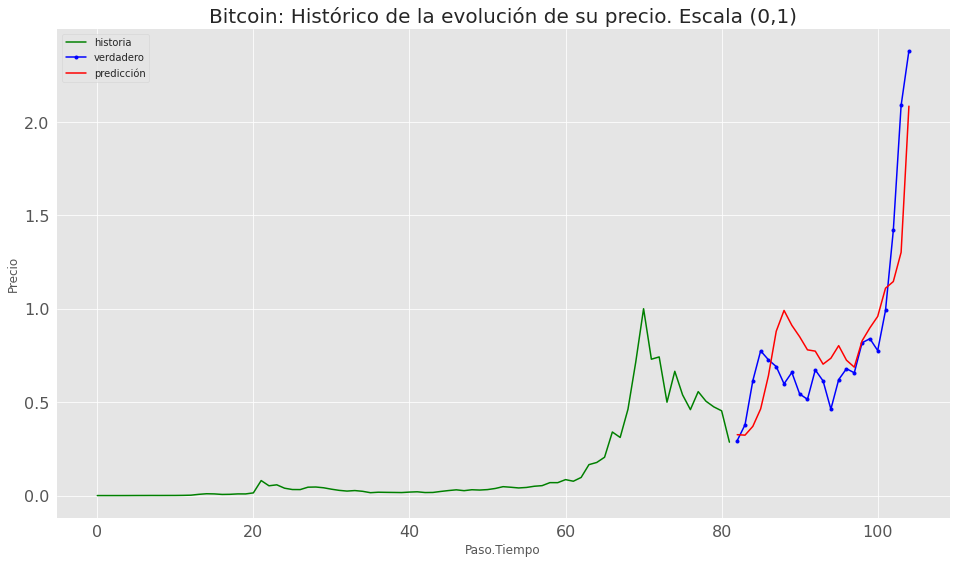

In [541]:
fig, ax = plt.subplots(1, figsize=(16, 9))
plt.plot(np.arange(0, len(y_train_p)), y_train_p, 'g', label="historia")
plt.plot(np.arange(len(y_train_p), len(y_train_p) + len(y_test_p)), y_test_p, marker='.', color='b',label="verdadero")
plt.plot(np.arange(len(y_train_p), len(y_train_p) + len(y_test_p)), y_pred_p, 'r', label="predicción")
plt.ylabel('Precio')
plt.xlabel('Paso.Tiempo')
plt.title("Bitcoin: Histórico de la evolución de su precio. Escala (0,1)", size = 20)
plt.legend()
plt.savefig("bitcoin_LSTM.png",bbox_inches='tight');
plt.show();

In [522]:
wandb.log({"Resultados del Prónostico con LSTM - Contraste con toda la serie": wandb.Image("./bitcoin_LSTM.png")})

**Evaluación del modelo**

Para evaluar el modelo y contrastarlo con el obtenido en la sección de SARIMAX, debemos convertir los datos nuevamente en la escala normal.

In [544]:
y_test = scaler.inverse_transform(y_test_p)
y_pred = scaler.inverse_transform(pred)

In [548]:
rms_LSTM = np.sqrt(np.mean(np.power(y_pred-y_test,2)))
mse_LSTM = mean_squared_error(y_pred, y_test)
mae_LSTM = median_absolute_error(y_test, y_pred)
print("MAE:",mae_LSTM)
print("RMS:", rms_LSTM)
print("MSE", mse_LSTM)

MAE: 2538.7469502500007
RMS: 3600.178648841291
MSE 12961286.303572701


# 💰 **Conclusión**

Las métricas encontradas para medir el desempeño de nuestro modelo SARIMA fueron:
* MAE: 1315.4
* RMS: 2358.9
* MSE 5.564.849.8

Las métricas calculadas para medir el desempeño de nuestra LSTM fueron:
* MAE: 2538.7469502500007
* RMS: 3600.178648841291
* MSE 12.961.286.303572701

Realizando el contraste de las métricas calculadas de los dos modelos podemos afirmar lo siguiente:

El modelo SARIMA se desempeña mucho mejor que nuestra LSTM, adicionalmente, es fácil de entrenar y no requiere tanto tiempo computacional como nuestra LSTM.


**¿Te arriesgarías a invertir en Bitcoin teniendo en cuenta los resultados de nuestro modelo?**